In [ ]:
pip install qiskit==0.45.0

In [ ]:
pip install qiskit-aer

In [ ]:
pip install qiskit-ibmq-provider

In [ ]:
pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

In [ ]:
pip install pylatexenc

In [ ]:
pip install qiskit-finance

# Quantum Fourier Transform

In [21]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import *
from qiskit_aer import Aer
# from qiskit_ibmq_provider import IBMQ
# from qiskit.providers.ibmq import least_busy
# from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import matplotlib.pyplot as plt

Building the Circuit

In [22]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit



In [67]:
def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)

    return circuit



In [68]:
from qiskit_textbook.widgets import scalable_circuit
# Let's see how it looks:
qc = QuantumCircuit(4)
qft(qc,4)
#qc.draw()
scalable_circuit(qft)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x06\x05\x00\x00\x01o\x08\x06\x00\x00\x00j\xc2\xcb.\x…

Implementation of QFT

computational basis


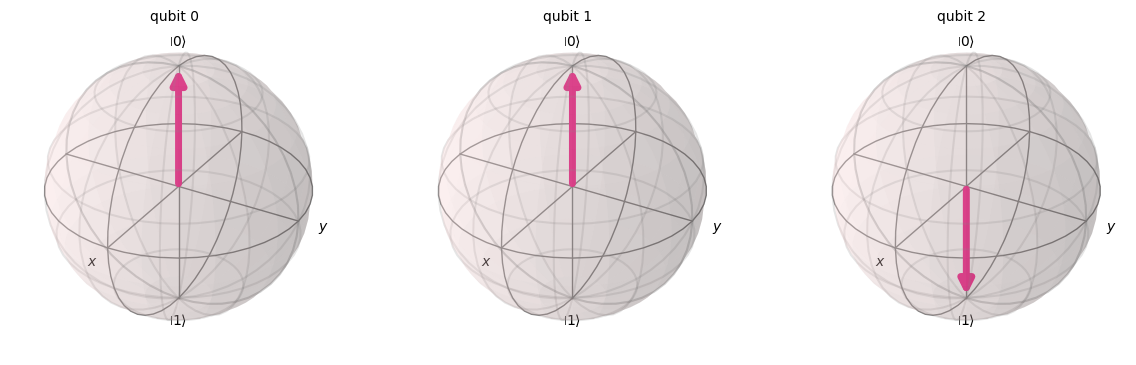

In [69]:
#on a state |001>

qc=QuantumCircuit(3)

qc.x(2)


print("computational basis")
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()

plot_bloch_multivector(statevector)

fourier basis


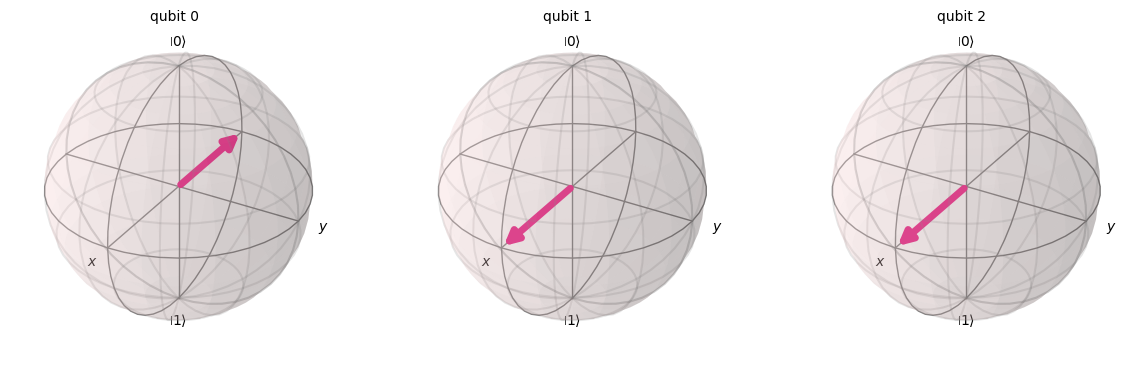

In [70]:
print("fourier basis")
qc=QuantumCircuit(3)

qc.x(2)

qftqc=qft(qc,3)
#qftqc.draw()
qftqc.save_statevector()
statevector = sim.run(qftqc).result().get_statevector()
#print(statevector)
plot_bloch_multivector(statevector)

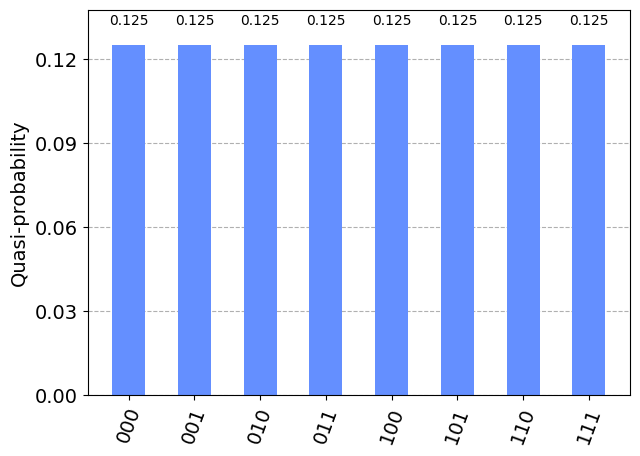

In [71]:
#probability distribution of QFT|0110>

backend = Aer.get_backend("qasm_simulator")
simulate = execute(qftqc, backend=backend, shots=1024).result()
simulate.get_counts()
plot_histogram(simulate.get_counts())

Applying QFT on a normal distribution

In [72]:
n=7
def Gauss(x, A, B):
    y = A*np.exp(-1*B*x**2)
    return y
r=np.linspace(0,(2**n)-1,2**n)
#rf=fftfreq(2**n)
k=[]
for i in range(2**(n-1)):
  k.append(i/2**n)
for i in range(2**(n-1),2**n):
  k.append((i/2**n)-1)



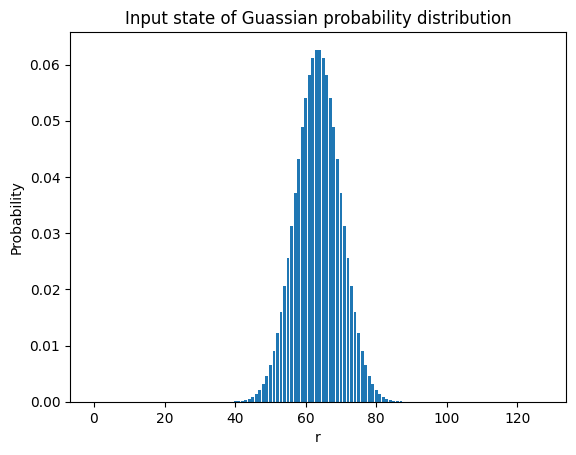

In [73]:
from qiskit_finance.circuit.library.probability_distributions import NormalDistribution

nqc = NormalDistribution(n,sigma=1,bounds=(-10, 10))
plt.bar(r,nqc.probabilities)
plt.title("Input state of Gaussian probability distribution")
plt.xlabel("r")
plt.ylabel("Probability")
plt.show()


In [74]:
#applying QFT
def QFT_probability(n,s):
  nqc = NormalDistribution(n,sigma=s,bounds=(-10, 10))# input normal distribution (in the 01 basis)
  QFT_nqc=qft(nqc,n)

  Fnqc_init = QFT_nqc.copy()
  Fnqc_init.save_statevector()
  backend = Aer.get_backend("aer_simulator")
  Ftqc = transpile(Fnqc_init, backend)
  job = backend.run(Ftqc, shots=5000)
  result = job.result()
  counts = result.get_counts(Ftqc)

  basis_states = [format(i, '0{}b'.format(n)) for i in range(2**n)]

  # Create an ordered dictionary to maintain the order of basis states
  from collections import OrderedDict
  ordered_counts = OrderedDict()

  # Add the counts to the ordered dictionary, filling in missing counts with 0
  for state in basis_states:
      if state in counts:
          ordered_counts[state] = counts[state]
      else:
          ordered_counts[state] = 0



  prob=list(ordered_counts.values())
  state=list(ordered_counts)

  return prob



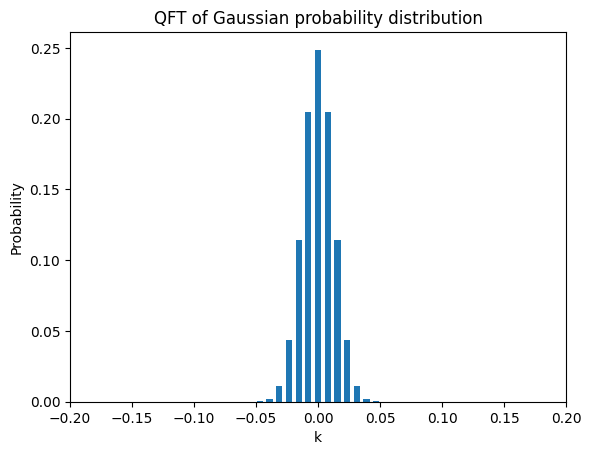

In [81]:
prob=QFT_probability(n,1)
plt.bar(k,prob,width=.005)
plt.title("QFT of Gaussian probability distribution")
plt.xlabel("k")
plt.ylabel("Probability")
plt.xlim(-.2,.2)
plt.show()
#plot_histogram(ordered_counts)


Trying this on Gaussian of different standard deviation

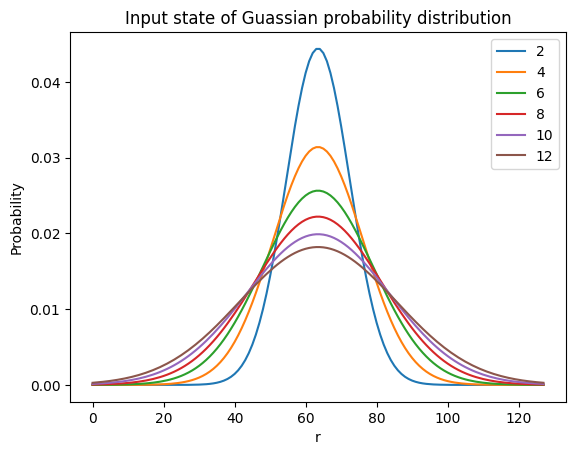

In [76]:
# for different values of sigma
from qiskit_finance.circuit.library.probability_distributions import NormalDistribution
sig=[2,4,6,8,10,12]
for i in range(len(sig)):
  s=sig[i]
  nqc = NormalDistribution(n,sigma=s,bounds=(-10, 10))
  plt.plot(r,nqc.probabilities,label=s)
plt.title("Input state of Gaussian probability distribution")
plt.xlabel("r")
plt.ylabel("Probability")
plt.legend()
plt.show()


Output of QFT


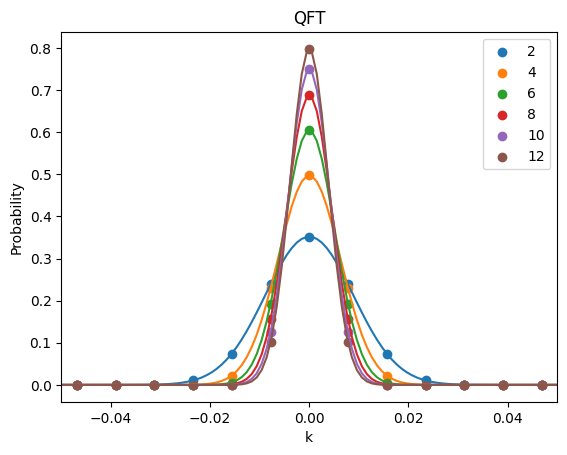

In [77]:
from scipy.optimize import curve_fit
print("Output of QFT")
xnew=np.linspace(-0.05,0.05,100)
for i in range(len(sig)):
  s=sig[i]
  #nqc = NormalDistribution(n,sigma=s,bounds=(-10, 10))
  y_data=QFT_probability(n,s)
  plt.scatter(k,y_data,label=s)
  #gaussian fit
  x_data = np.asarray(k)
  y_data = np.asarray(y_data)
  parameters, covariance = curve_fit(Gauss,x_data,y_data)
  fit_A = parameters[0]
  fit_B = parameters[1]
  fit_y = Gauss(xnew, fit_A, fit_B)
  plt.plot(xnew, fit_y)
plt.title("QFT")
plt.xlabel("k")
plt.ylabel("Probability")
plt.xlim(-.05,.05)
plt.legend()
plt.show()

# Inverse QFT

In [78]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])

    return circuit.decompose() # .decompose() allows us to see the individual gates

Applying inverse fourier transform on the QFT output state of the above Gaussian distribution.

This should give back the Gaussian distribution.

In [79]:
nqc = NormalDistribution(n,sigma=1,bounds=(-10, 10))# input normal distribution (in the 01 basis)
QFT_nqc=qft(nqc,n)
inv=inverse_qft(QFT_nqc,n)


Inqc_init = inv.copy()
Inqc_init.save_statevector()
backend = Aer.get_backend("aer_simulator")
Itqc = transpile(Inqc_init, backend)
job = backend.run(Itqc, shots=5000)
result = job.result()
counts = result.get_counts(Itqc)

basis_states = [format(i, '0{}b'.format(n)) for i in range(2**n)]

# Create an ordered dictionary to maintain the order of basis states
from collections import OrderedDict
ordered_counts = OrderedDict()

# Add the counts to the ordered dictionary, filling in missing counts with 0
for state in basis_states:
    if state in counts:
        ordered_counts[state] = counts[state]
    else:
        ordered_counts[state] = 0

prob=list(ordered_counts.values())
state=list(ordered_counts)



Text(0, 0.5, 'probability')

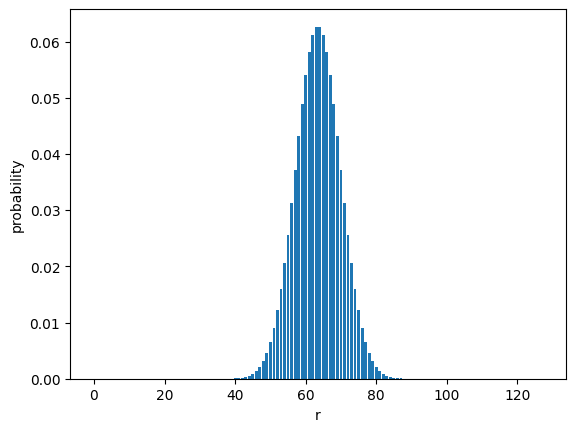

In [80]:

plt.bar(r,prob)
plt.xlabel("r")
plt.ylabel("probability")

# Quantum Phase Estimation

In [113]:
import math


# Create QPE circuit component by component

#Inverse QFT
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)


# Create and set up circuit for 3 measurement qubits
qpe_3 = QuantumCircuit(4, 3)

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe_3.h(qubit)

# Prepare our eigenstate |psi>:
qpe_3.x(3)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe_3.cp(angle, counting_qubit, 3);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe_3, 3)

# Measure of course!
for n in range(3):
    qpe_3.measure(n,n)

qpe_3.draw()

┌───┐                                                            »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────»
     ├───┤ │                                                          »
q_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
     ├───┤ │         │         │                                      »
q_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
     ├───┤ │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
q_3: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
     └───┘                                                            »
c: 3/═════════════════════════════════════════════════════════════════»
                                                                      »
«                  ┌───┐                                   ┌─┐           
«q_0: ───────────X─┤ H ├─■──────────────■──────────────────┤M├───────────
«                │ └───┘ │P(-π/2) ┌───┐ │                  └╥┘     ┌─┐   
«q_1: ───────────┼───────■────────┤ H ├─┼─────────■─────────╫──────┤M├───
«                │                └───┘ │P(-π/4)  │P(-π/2)  ║ ┌───┐└╥┘┌─┐
«q_2: ─■─────────X──────────────────────■─────────■─────────╫─┤ H ├─╫─┤M├
«      │P(2π/3)                                             ║ └───┘ ║ └╥┘
«q_3: ─■────────────────────────────────────────────────────╫───────╫──╫─
«                                                           ║       ║  ║ 
«c: 3/══════════════════════════════════════════════════════╩═══════╩══╩═
«                                                           0       1  2

In [121]:
# Create and set up circuit for 3 measurement qubits

def qpe_n(n,theta): #n = no. of measurement qubits
    qpe = QuantumCircuit(n+1, n)

# Apply H-Gates to counting qubits:
    for qubit in range(n):
        qpe.h(qubit)

    # Prepare our eigenstate |psi>:
    qpe.x(n)

    # Do the controlled-U operations:
    angle = theta
    repetitions = 1
    for counting_qubit in range(n):
        for i in range(repetitions):
            qpe.cp(angle, counting_qubit, n);
        repetitions *= 2

    # Do the inverse QFT:
    inverse_qft(qpe, n)

    # Measure of course!
    for j in range(n):
        qpe.measure(j,j)

    return qpe


In [122]:
#for 3 measurement qubits and phase=1/3 rad
x=qpe_n(3,2*math.pi/3)
x.draw()

┌───┐                                                            »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────»
     ├───┤ │                                                          »
q_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
     ├───┤ │         │         │                                      »
q_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
     ├───┤ │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
q_3: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
     └───┘                                                            »
c: 3/═════════════════════════════════════════════════════════════════»
                                                                      »
«               ┌───────────────────┐┌─┐      
«q_0: ──────────┤0                  ├┤M├──────
«               │                   │└╥┘┌─┐   
«q_1: ──────────┤1 circuit-46711_dg ├─╫─┤M├───
«               │                   │ ║ └╥┘┌─┐
«q_2: ─■────────┤2                  ├─╫──╫─┤M├
«      │P(2π/3) └───────────────────┘ ║  ║ └╥┘
«q_3: ─■──────────────────────────────╫──╫──╫─
«                                     ║  ║  ║ 
«c: 3/════════════════════════════════╩══╩══╩═
«                                     0  1  2

<ipython-input-129-a067986c7ebc>:6: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  results = aer_sim.run(qobj).result()


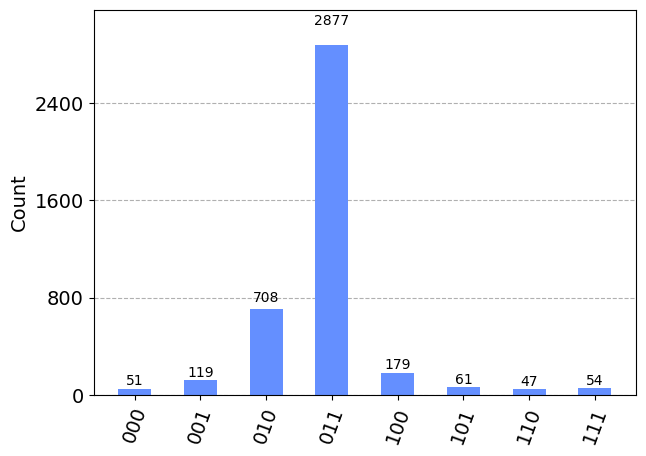

In [129]:
# Let's see the results!
aer_sim = Aer.get_backend('aer_simulator')
shots = 4096
t_x = transpile(x, aer_sim)
qobj = assemble(t_x, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [130]:
# Find the maximum count
max_count = max(answer.values())
values = list(answer.values())
values.remove(max_count)

# Find the second maximum count
sec_max_count = max(values)

print("Maximum value of y:", max_count)
print("Second maximum value of y:", sec_max_count)

Maximum value of y: 2877
Second maximum value of y: 708


In [131]:
x_values = list(answer.keys())
y_values = list(answer.values())
max_index = y_values.index(max_count)
sec_max_index = y_values.index(sec_max_count)
x_at_max_count = x_values[max_index]
x_at_sec_max_count = x_values[sec_max_index]

print("X value at maximum count:", x_at_max_count)
print("X value at second maximum count:", x_at_sec_max_count)

decimal_number = int(x_at_max_count, 2)
sec_decimal_number = int(x_at_sec_max_count, 2)

print("Decimal equivalent(max):", decimal_number)
print("Decimal equivalent(second max):", sec_decimal_number)

X value at maximum count: 011
X value at second maximum count: 010
Decimal equivalent(max): 3
Decimal equivalent(second max): 2


In [134]:
phase_rad1 = decimal_number/2**3
phase_deg1 = math.degrees(phase_rad1)
phase_rad2 = sec_decimal_number/2**3
phase_deg2 = math.degrees(phase_rad2)

print("Phase Estimated 1:", phase_rad1, "radians", "or", phase_deg1, "degrees")
print("Phase Estimated 2:", phase_rad2, "radians", "or", phase_deg2, "degrees")

Phase Estimated 1: 0.375 radians or 21.48591731740587 degrees
Phase Estimated 2: 0.25 radians or 14.32394487827058 degrees


In [148]:
#for 5 measurement qubits and phase=1/3 rad
y=qpe_n(5,2*math.pi/3)
y.draw()

┌───┐                                                            »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────»
     ├───┤ │                                                          »
q_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
     ├───┤ │         │         │                                      »
q_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
     ├───┤ │         │         │         │         │         │        »
q_3: ┤ H ├─┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
     ├───┤ │         │         │         │         │         │        »
q_4: ┤ H ├─┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
     ├───┤ │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
q_5: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
     └───┘                                                            »
c: 5/═════════════════════════════════════════════════════════════════»
                                                                      »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ─■────────────────────────────────────────────────────────────────────»
«      │                                                                    »
«q_3: ─┼─────────■─────────■─────────■─────────■─────────■─────────■────────»
«      │         │         │         │         │         │         │        »
«q_4: ─┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
«      │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
«q_5: ─■─────────■─────────■─────────■─────────■─────────■─────────■────────»
«                                                                           »
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_3: ─■─────────■──────────────────────────────────────────────────────────»
«      │         │                                                          »
«q_4: ─┼─────────┼─────────■─────────■─────────■─────────■─────────■────────»
«      │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
«q_5: ─■─────────■─────────■─────────■─────────■─────────■─────────■────────»
«                                                                           »
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_3: ─────────────────────────────────

<ipython-input-151-98cae2755a4f>:6: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  results = aer_sim.run(qobj).result()


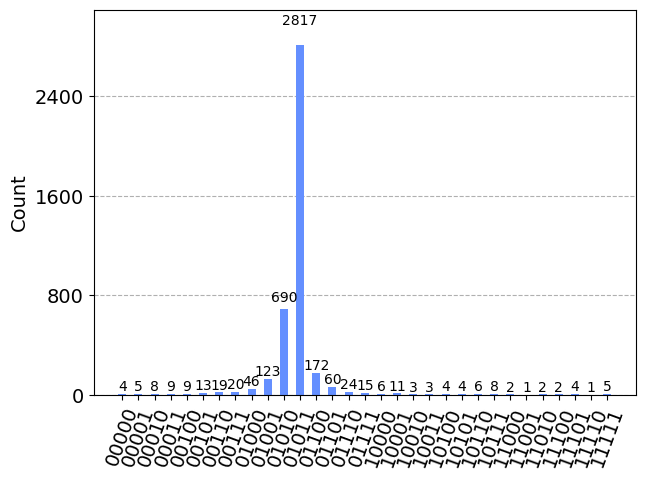

In [151]:
# Let's see the results!
aer_sim = Aer.get_backend('aer_simulator')
shots = 4096
t_y = transpile(y, aer_sim)
qobj = assemble(t_y, shots=shots)
results = aer_sim.run(qobj).result()
answer2 = results.get_counts()

plot_histogram(answer2)

In [152]:
# Find the maximum count
max_count = max(answer2.values())
values = list(answer2.values())
values.remove(max_count)

# Find the second maximum count
sec_max_count = max(values)

print("Maximum value of y:", max_count)
print("Second maximum value of y:", sec_max_count)

Maximum value of y: 2817
Second maximum value of y: 690


In [153]:
x_values = list(answer2.keys())
y_values = list(answer2.values())
max_index = y_values.index(max_count)
sec_max_index = y_values.index(sec_max_count)
x_at_max_count = x_values[max_index]
x_at_sec_max_count = x_values[sec_max_index]

print("X value at maximum count:", x_at_max_count)
print("X value at second maximum count:", x_at_sec_max_count)

decimal_number = int(x_at_max_count, 2)
sec_decimal_number = int(x_at_sec_max_count, 2)

print("Decimal equivalent(max):", decimal_number)
print("Decimal equivalent(second max):", sec_decimal_number)

X value at maximum count: 01011
X value at second maximum count: 01010
Decimal equivalent(max): 11
Decimal equivalent(second max): 10


In [154]:
phase_rad1 = decimal_number/2**5
phase_deg1 = math.degrees(phase_rad1)
phase_rad2 = sec_decimal_number/2**5
phase_deg2 = math.degrees(phase_rad2)

print("Phase Estimated 1:", phase_rad1, "radians", "or", phase_deg1, "degrees")
print("Phase Estimated 2:", phase_rad2, "radians", "or", phase_deg2, "degrees")

Phase Estimated 1: 0.34375 radians or 19.695424207622047 degrees
Phase Estimated 2: 0.3125 radians or 17.904931097838226 degrees
